In [78]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.datasets import boston_housing

import gc

tf.config.run_functions_eagerly(True)  # needed it for dubugging for memory

# loading data and preprocessing

# neural netowrk structure

In [79]:


(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print("x_train shape before normalization:", x_train.shape)
print("y_train shape:", y_train.shape)

mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

print("x_train shape after normalization and conversion:", x_train.shape)

INPUT_SIZE = x_train.shape[1]
HIDDEN_SIZE = 32
OUTPUT_SIZE = 1

w1_size = INPUT_SIZE * HIDDEN_SIZE
b1_size = HIDDEN_SIZE
w2_size = HIDDEN_SIZE * OUTPUT_SIZE
b2_size = OUTPUT_SIZE

x_train shape before normalization: (404, 13)
y_train shape: (404,)
x_train shape after normalization and conversion: (404, 13)


In [80]:
def sigmoid(x):
    return tf.nn.sigmoid(x)

def softmax(x):
    return tf.nn.softmax(x)

def decode_weights(vector):

    idx = 0
    w1 = tf.reshape(vector[idx:idx + w1_size], [INPUT_SIZE, HIDDEN_SIZE])
    idx += w1_size

    b1 = vector[idx:idx + b1_size]
    idx += b1_size

    w2 = tf.reshape(vector[idx:idx + w2_size], [HIDDEN_SIZE, OUTPUT_SIZE])
    idx += w2_size

    b2 = vector[idx:idx + b2_size]

    return w1, b1, w2, b2

def forward_pass(X, vector):
    w1, b1, w2, b2 = decode_weights(vector)
    hidden = sigmoid(tf.matmul(X, w1) + b1)
    output = tf.matmul(hidden, w2) + b2
    return output

# def fitness(vector, X, y_true, batch_size=1000):
#     indices = np.random.choice(X.shape[0], batch_size, replace=False)
#     X_batch = tf.gather(X, indices)
#     y_batch = tf.gather(y_true, indices)
#     y_pred = forward_pass(X_batch, vector)
#     loss = tf.keras.losses.categorical_crossentropy(y_batch, y_pred)
#     return tf.reduce_mean(loss)
    
def fitness(vector, X, y_true):
    y_pred = forward_pass(X, vector)
    loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return tf.reduce_mean(loss)



In [81]:
total_weights = INPUT_SIZE * HIDDEN_SIZE + HIDDEN_SIZE + HIDDEN_SIZE * OUTPUT_SIZE + OUTPUT_SIZE


# functions for the DE

In [82]:


def initialize_population(population_size, D, input_dim=784, output_dim=10):
    
    xavier_scaling = tf.sqrt(6.0 / tf.cast(input_dim + output_dim, tf.float32))
    population = tf.random.uniform(
        shape=(population_size, D),
        minval=-xavier_scaling,
        maxval=xavier_scaling,
        dtype=tf.float32
    )
    
    return population



    


In [83]:

def random_vectors(population, current_idx):
    indices = tf.range(NP)
    mask = indices != current_idx
    valid_indices = tf.boolean_mask(indices, mask)
    selected_indices = tf.random.shuffle(valid_indices)[:3]
    return [population[idx] for idx in selected_indices]

    

In [84]:
def mutate(x1, x2, x3, F, D, L=-1, H=1):

    v = x3 + F * (x1 - x2)
    
    out_of_bounds = tf.logical_or(v < L, v > H) # returns tensor fo booleans where true is erorr
    
    random_values = L + tf.random.uniform(shape=(D,), dtype=tf.float32) * (H - L)
    
    v = tf.where(out_of_bounds, random_values, v) # checks where true and takes value from the random value if false takes from v
    
    return v

 <p>example of how we did the mutate and how mask works</p>
<img src="Screenshot_20250424_015153.png" alt="Project Screenshot" width="600"/>

In [85]:
def crossover(target_vector, mutant_vector, CR, D):

    # instead of loop and check we make the whole vecotor once and check with mask
    r = tf.random.uniform(shape=(D,), dtype=tf.float32)
    
    
    mask = r < CR  # mask is tensor flow boolean vecotr
    
    trial_vector = tf.where(mask, mutant_vector, target_vector)
    
    return trial_vector

In [86]:
def extinction(population_variable, extinction_percentage, NP, D, fitness_func, x_train, y_train):


    num_survivors = tf.cast(tf.round(tf.cast(NP, tf.float32) * (1.0 - extinction_percentage)), tf.int32)  # calculated using NP and percnetange 

    num_survivors = tf.maximum(num_survivors, 1)  # takes maximum between num and 1 so at least 1 lives

    num_new = NP - num_survivors
    
    print(f"Keeping {num_survivors} best, replacing {num_new} individuals")
# calculate fitnees for each ind for soring 
    current_fitness_scores = [fitness_func(ind, x_train, y_train) for ind in population_variable]  

    current_fitness_scores_np = np.array([f.numpy() for f in current_fitness_scores]) 
# sort by fitness then keep from start :num of survivors 
    survivor_indices = tf.argsort(current_fitness_scores_np)[ : num_survivors]  

    survivors = tf.gather(population_variable, survivor_indices)  # survivor indivisuals 

    new_individuals = initialize_population(population_size=num_new, D=D)

    new_population_tensor = tf.concat([survivors, new_individuals], axis=0)

    new_population_tensor = tf.random.shuffle(new_population_tensor) # shuffle the survivors for better diversity 

    return new_population_tensor

# main evolve function

In [87]:

def evolve(population, GEN, NP, D, F, CR, x_train, y_train, fitness_func, L=-0.5, H=0.5, extinction_percentage=0.0, extinction_generation=0.0,): 

    if extinction_generation > 0 and extinction_percentage > 0: 
        print(f"  Extinction enabled: {extinction_percentage*100:.1f}% every {extinction_generation} generations.") 
    else:
         print("  Extinction disabled.")

    best_fitness = 9999999
    best_solution = None
    fitness_history = []

    for g in range(GEN):

        new_population = [tf.identity(ind) for ind in population] #copy of the population for this generation to work on it

        for j in range(NP):  # j here represent the target vector so i loop for each target and do my DE

            v1, v2, v3 = random_vectors(population, j) 
            mutant_vector = mutate(v1, v2, v3, F, D, L, H)

            target_vector = population[j] 

            trial_vector = crossover(target_vector, mutant_vector, CR, D)


            trial_fitness = fitness_func(trial_vector, x_train, y_train)
            target_fitness = fitness_func(target_vector, x_train, y_train) 

            if trial_fitness < target_fitness:
                new_population[j] = trial_vector 

                if trial_fitness < best_fitness:  # to update best solution to reutrn it later for network evaluation
                    best_solution = tf.identity(trial_vector)
                    best_fitness = trial_fitness



        # some kind of elitsm 

        worst_idx = np.argmax([fitness_func(ind, x_train, y_train) for ind in new_population])  #get highest fitness / worst indivsual
        worst_fitness = fitness_func(new_population[worst_idx], x_train, y_train)
        if worst_fitness > best_fitness:
            new_population[worst_idx] = tf.identity(best_solution)




        #extination part


        if extinction_generation > 0 and extinction_percentage > 0 and (g + 1) % extinction_generation == 0:  # 


            print(f"\n--- ⚠️⚠️Triggering Extinction Event at Generation {g+1} 🦖🦖⚠️⚠️---") 

            population_as_tensor = tf.stack(new_population) # convert to list of indivusials for effiency with tensorflow

            new_population_tensor = extinction(population_as_tensor, extinction_percentage, NP, D, fitness_func, x_train, y_train)

            new_population = tf.unstack(new_population_tensor) #  convert back


            best_idx_after_extinction = np.argmin([fitness_func(ind, x_train, y_train) for ind in new_population]) 
            best_fitness = float(fitness_func(new_population[best_idx_after_extinction], x_train, y_train))
            best_solution = tf.identity(new_population[best_idx_after_extinction]) 
            print(f"  New best fitness after extinction: {best_fitness:.6f}") 
            gc.collect()



        # replacing population 
        for i in range(NP):
            population[i].assign(new_population[i]) 
        del new_population  # for memory issuie since tensorflow after replacing leaves the old as garbage 
        gc.collect()  

        if g % 20 == 0:  
            print(f"Generation {g+1}/{GEN}: Best fitness (loss) = {best_fitness:.6f}") 

        fitness_history.append(best_fitness)

    return best_solution, fitness_history, population

# gentic algorithm

In [88]:
def tournament_selection(population, fitness_scores, tournament_size):

    population_size = len(population)
    
    candidates = np.random.choice(population_size, tournament_size, replace=False)
    
    candidate_fitness = [fitness_scores[i] for i in candidates]
    
    winner_idx = candidates[tf.argmin(candidate_fitness)]
    return winner_idx

In [89]:
def genetic_crossover(parent1, parent2):

    mask = tf.cast(tf.random.uniform(shape=parent1.shape) < 0.5, tf.float32)  # to summarize this just a vecotr of zeros and ones and the .5 control the bian to each parent 
    
    child = parent1 * mask + parent2 * (1 - mask)
    
    return child

In [90]:
def genetic_mutation(individual, mutation_rate):  #non uniform using gaussian distrubtion


    mutation_mask = tf.cast(tf.random.uniform(shape=individual.shape) < mutation_rate, tf.float32) # again some zeros and ones
    
    mutation = tf.random.normal(shape=individual.shape, mean=0.0, stddev=0.1)
    
    # Apply mutation
    mutated = individual + mutation * mutation_mask  #  𝑥'  = 𝑥  + N(0,std)   the mutation mask to make sure only %mtation rate genes change 
    
    return mutated

In [91]:
def genetic_algorithm(de_population, x_train, y_train, fitness_func, generations=500, mutation_rate=0.05, tournament_size=3):
    population = [tf.Variable(ind) for ind in de_population]
    population_size = len(population)

    fitness_scores = [float(fitness_func(ind, x_train, y_train).numpy()) for ind in population]
    best_idx = np.argmin(fitness_scores)
    best_weights = tf.identity(population[best_idx])
    best_fitness = fitness_scores[best_idx]

    fitness_history = [best_fitness]  # store as floats

    print(f"Starting GA with initial fitness (loss): {best_fitness:.6f}")

    for gen in range(generations):
        new_population = []

        for _ in range(population_size):
            parent1_idx = tournament_selection(population, fitness_scores, tournament_size)
            parent2_idx = tournament_selection(population, fitness_scores, tournament_size)
            tries = 0
            while parent2_idx == parent1_idx and tries < 10:
                parent2_idx = tournament_selection(population, fitness_scores, tournament_size)
                tries += 1

            child = genetic_crossover(population[parent1_idx], population[parent2_idx])
            child = genetic_mutation(child, mutation_rate)
            new_population.append(tf.Variable(child))  # ensure Variable for next gen

        population = new_population
        del new_population

        fitness_scores = [float(fitness_func(ind, x_train, y_train).numpy()) for ind in population]
        current_best_idx = np.argmin(fitness_scores)
        current_best_fitness = fitness_scores[current_best_idx]

        if current_best_fitness < best_fitness:
            best_weights = tf.identity(population[current_best_idx])
            best_fitness = current_best_fitness

        fitness_history.append(best_fitness)

        if gen % 10 == 0:
            import gc
            gc.collect()
            print(f"Generation {gen+1}/{generations}: Best fitness (loss) = {best_fitness:.6f}")

    print(f"GA best fitness (loss): {best_fitness:.6f}")
    return best_weights, fitness_history, population

In [92]:
def de_ga_hybrid(population, GEN_DE, NP, D, F, CR, x_train, y_train, fitness_func, ga_generations=500, L=-0.5, H=0.5, extinction_percentage=0.0, extinction_generation=0.0): 
    best_de_solution, de_history, final_de_population = evolve(
        population, GEN_DE, NP, D, F, CR, x_train, y_train, fitness_func, L, H,
        extinction_percentage=extinction_percentage, 
        extinction_generation=extinction_generation,  
    )

    print("DE complete starting GA")

    ga_solution, ga_history, gen_population = genetic_algorithm(
        final_de_population, x_train, y_train, fitness_func,
        generations=ga_generations, mutation_rate=0.05, tournament_size=3
    )

    de_fitness = float(fitness_func(best_de_solution, x_train, y_train).numpy())
    ga_fitness = float(fitness_func(ga_solution, x_train, y_train).numpy())

    print(f"DE best fitness: {de_fitness:.6f}")
    print(f"GA best fitness: {ga_fitness:.6f}")

    if ga_fitness < de_fitness:
        print("GA had the best overall fitness")
        best_solution = ga_solution
    else:
        print("DE solution was better")
        best_solution = best_de_solution

    return best_solution, de_history, ga_history, final_de_population

In [93]:
def ga_de_hybrid(population, GEN_DE, NP, D, F, CR, x_train, y_train, fitness_func, ga_generations=500, L=-0.5, H=0.5, extinction_percentage=0.0, extinction_generation=0.0): 

    print("Starting GA optimization...")
    ga_solution, ga_history, ga_population = genetic_algorithm(population, x_train, y_train, fitness_func, generations=ga_generations, mutation_rate=0.05, tournament_size=3)

    print("GA complete, starting DE optimization...")

    population_list_vars = [tf.Variable(ind) for ind in tf.unstack(ga_population)] # adapted input for evolve


    best_de_solution, de_history, final_de_population = evolve(
        population_list_vars, GEN_DE, NP, D, F, CR, x_train, y_train, fitness_func, L, H,
        extinction_percentage=extinction_percentage, # argument added
        extinction_generation=extinction_generation, # argument added
        initialize_population=initialize_population # argument added
    )

    ga_fitness = fitness_func(ga_solution, x_train, y_train)
    de_fitness = fitness_func(best_de_solution, x_train, y_train)

    print(f"GA best fitness: {ga_fitness:.6f}")
    print(f"DE best fitness: {de_fitness:.6f}")
    print(f"Improvement: {(ga_fitness - de_fitness):.6f} ({(ga_fitness - de_fitness)/ga_fitness*100:.2f}%)")

    if de_fitness < ga_fitness:
        print("DE improved on the GA solution!")
        best_solution = best_de_solution
    else:
        print("GA solution was better!")
        best_solution = ga_solution


    return best_solution, ga_history, de_history, final_de_population

In [ ]:
NP = 50
GEN = 500
seed = 24
extinction_perc = 0.1 
extinction_gen = 100
np.random.seed(seed)
tf.random.set_seed(seed)
D = w1_size+ b1_size+ w2_size+b2_size
population = initialize_population(population_size=NP, D=D)
print("population shape is: ", population.shape)
population = tf.Variable(population)

rres, de_history, ga_history, pop = de_ga_hybrid(
    population,
    GEN,
    NP,
    D,
    0.8,
    0.7,
    x_train,
    y_train,
    fitness,
    ga_generations=400,
    L=-1,
    H=1,
    extinction_generation=extinction_gen,
    extinction_percentage=extinction_perc
)


population shape is:  (50, 481)
  Extinction enabled: 10.0% every 100 generations.
Generation 1/500: Best fitness (loss) = 568.135986
Generation 21/500: Best fitness (loss) = 335.480469
Generation 41/500: Best fitness (loss) = 274.065765
Generation 61/500: Best fitness (loss) = 196.990021
Generation 81/500: Best fitness (loss) = 162.284576

--- ⚠️⚠️Triggering Extinction Event at Generation 100 🦖🦖⚠️⚠️---
Keeping 45 best, replacing 5 individuals
  New best fitness after extinction: 139.413361
Generation 101/500: Best fitness (loss) = 139.413361
Generation 121/500: Best fitness (loss) = 114.971291
Generation 141/500: Best fitness (loss) = 102.361519
Generation 161/500: Best fitness (loss) = 90.214546
Generation 181/500: Best fitness (loss) = 84.142296

--- ⚠️⚠️Triggering Extinction Event at Generation 200 🦖🦖⚠️⚠️---
Keeping 45 best, replacing 5 individuals
  New best fitness after extinction: 77.896927
Generation 201/500: Best fitness (loss) = 77.896927
Generation 221/500: Best fitness (lo

In [3]:
def evaluate_model(best_solution, x_test, y_test):
    predictions = forward_pass(x_test, best_solution)
    mse = tf.keras.losses.MeanSquaredError()(y_test, predictions)
    rmse = tf.sqrt(mse)

    mae = tf.keras.losses.MeanAbsoluteError()(y_test, predictions)

    print("test RMSE ",rmse)
    print("test MAE ",mae)
    print("test MSE",mse)

    return rmse.numpy(), predictions.numpy()

In [4]:
import plotly.graph_objects as go

# Convert TensorFlow tensors to NumPy arrays for JSON serialization
de_history_np = [float(loss.numpy()) if hasattr(loss, 'numpy') else float(loss) for loss in de_history]
ga_history_np = [float(loss.numpy()) if hasattr(loss, 'numpy') else float(loss) for loss in ga_history]

# Create generation numbers for x-axis
de_generations = np.arange(len(de_history_np))
ga_generations = np.arange(len(de_history_np), len(de_history_np) + len(ga_history_np))

# Find min and max loss values
min_loss = min(min(de_history_np), min(ga_history_np))
max_loss = max(max(de_history_np), max(ga_history_np))

# Create figure
fig = go.Figure()

# Add DE history trace (blue)
fig.add_trace(
    go.Scatter(
        x=de_generations,
        y=de_history_np,
        mode='lines',
        name='DE Optimization',
        line=dict(color='blue')
    )
)

# Add GA history trace (red)
fig.add_trace(
    go.Scatter(
        x=ga_generations,
        y=ga_history_np,
        mode='lines',
        name='GA Refinement',
        line=dict(color='red')
    )
)

# Add vertical line at transition
fig.add_shape(
    type="line",
    x0=len(de_history_np)-1,
    y0=min_loss,
    x1=len(de_history_np)-1,
    y1=max_loss,
    line=dict(
        color="gray",
        width=1,
        dash="dash",
    )
)

# Add transition annotation
fig.add_annotation(
    x=len(de_history_np)-1,
    y=float(de_history_np[-1]),
    text="DE → GA Transition",
    showarrow=True,
    arrowhead=1,
    ax=0,
    ay=-40
)

# Update layout
fig.update_layout(
    title='Hybrid DE-GA Optimization Progress (Regression)',
    xaxis_title='Generation',
    yaxis_title='MSE Loss',
    height=600,
    width=900,
    legend=dict(
        x=0.01,
        y=0.99,
        bgcolor='rgba(255, 255, 255, 0.5)'
    ),
    hovermode='x unified'
)

# Customize hover information
fig.update_traces(
    hovertemplate='Generation: %{x}<br>Loss: %{y:.6f}'
)

# Display the figure
fig.show()

# Save as interactive HTML
fig.write_html("hybrid_optimization_progress_regression.html")

NameError: name 'de_history' is not defined

In [5]:
acc, pred  = evaluate_model(rres ,x_test , y_test)

NameError: name 'rres' is not defined

In [ ]:
# def visualize_predictions(x_test, y_test, predictions, probabilities, num_samples=5):

#     import matplotlib.pyplot as plt
#     import numpy as np
#     import random
    
#     # Get random samples
#     indices = random.sample(range(len(x_test)), num_samples)
    
#     # Set up the figure
#     fig, axes = plt.subplots(num_samples, 2, figsize=(12, 2*num_samples))
    
#     for i, idx in enumerate(indices):
#         # Original image
#         original_image = x_test[idx].numpy().reshape(28, 28)
#         true_label = np.argmax(y_test[idx])
#         pred_label = predictions[idx]
#         pred_prob = probabilities[idx][pred_label]
        
#         # Show image
#         axes[i, 0].imshow(original_image, cmap='gray')
#         axes[i, 0].set_title(f"True: {true_label}")
#         axes[i, 0].axis('off')
        
#         # Show probabilities
#         axes[i, 1].bar(range(10), probabilities[idx])
#         axes[i, 1].set_title(f"Pred: {pred_label} (Confidence: {pred_prob:.4f})")
#         axes[i, 1].set_xticks(range(10))
        
#     plt.tight_layout()
#     plt.show()


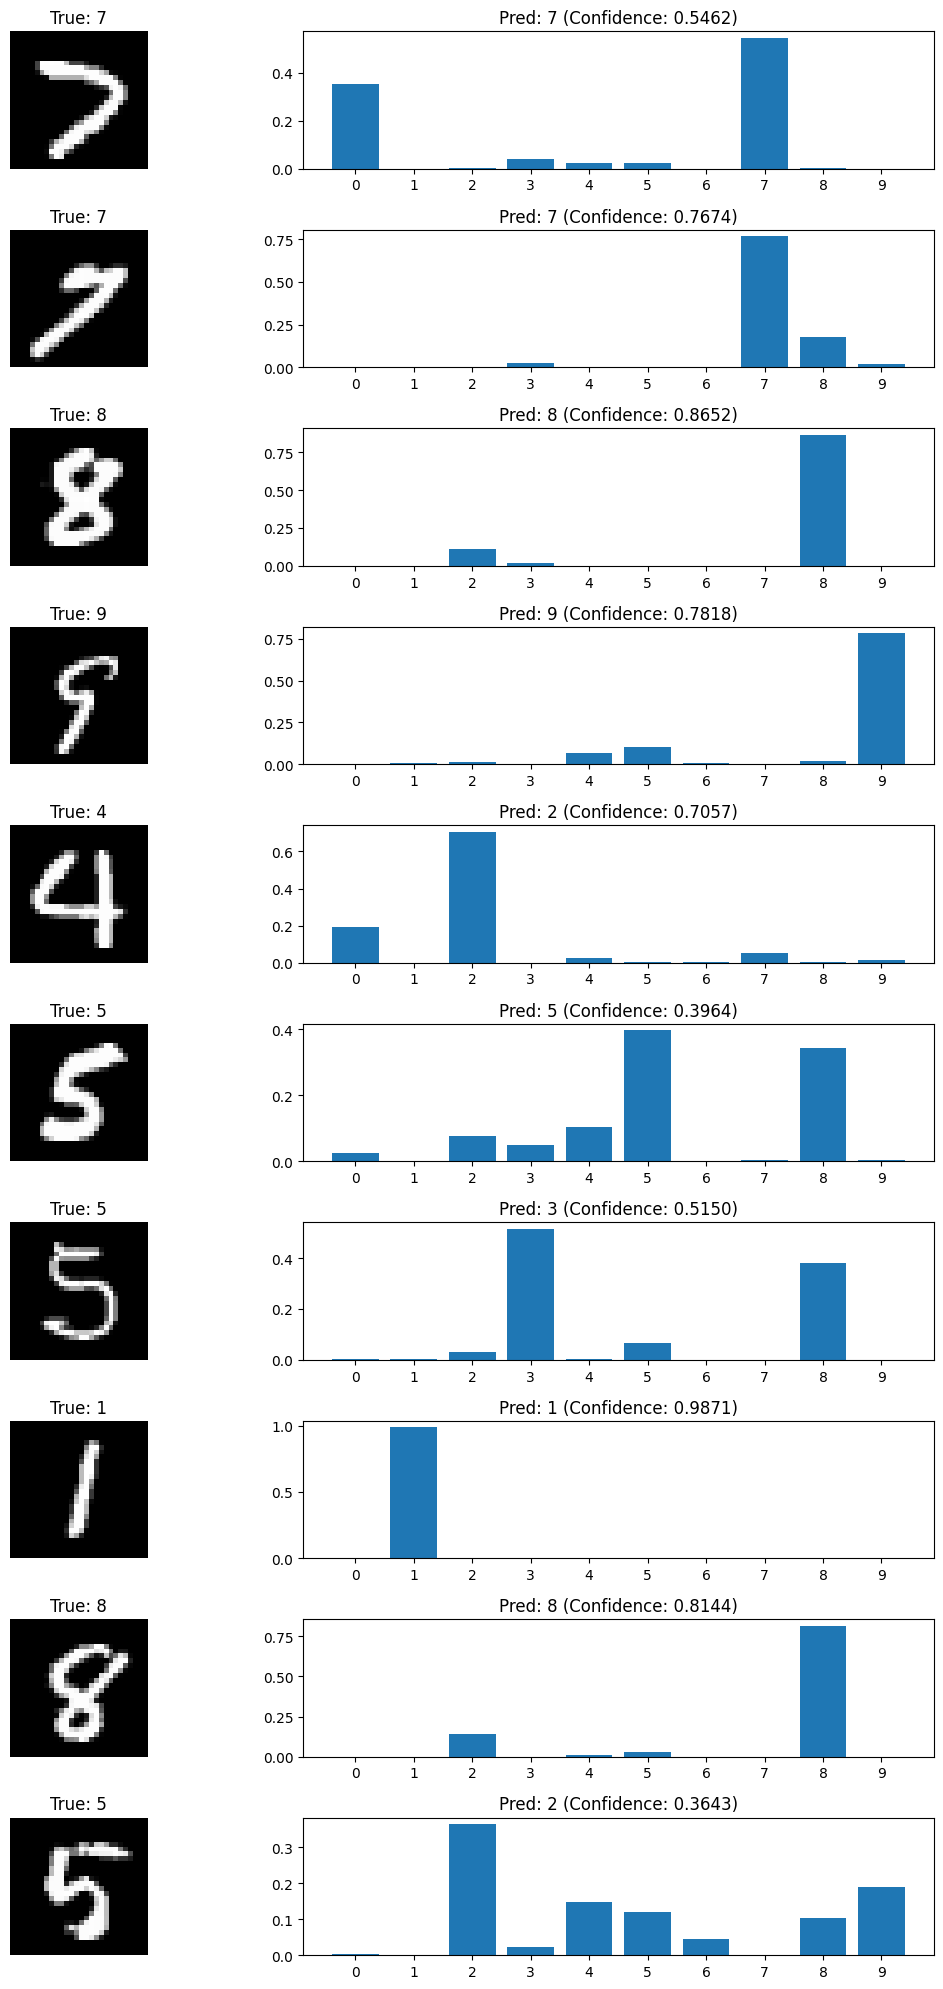

In [ ]:
# visualize_predictions(x_test, y_test_hot,pred,prob,10)